In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

## Metrics

In [2]:
def find_TP(y_true, y_pred):
    # counts the number of true positives (y_true = 1, y_pred = 1)
    return sum((y_true == 1) & (y_pred == 1))
def find_FN(y_true, y_pred):
    # counts the number of false negatives (y_true = 1, y_pred = 0)
    return sum((y_true == 1) & (y_pred == 0))
def find_FP(y_true, y_pred):
    # counts the number of false positives (y_true = 0, y_pred = 1)
    return sum((y_true == 0) & (y_pred == 1))
def find_TN(y_true, y_pred):
    # counts the number of true negatives (y_true = 0, y_pred = 0)
    return sum((y_true == 0) & (y_pred == 0))

def find_conf_matrix_values(y_true,y_pred):
    # calculate TP, FN, FP, TN
    TP = find_TP(y_true,y_pred)
    FN = find_FN(y_true,y_pred)
    FP = find_FP(y_true,y_pred)
    TN = find_TN(y_true,y_pred)
    return TP,FN,FP,TN
def my_confusion_matrix(y_true, y_pred):
    TP,FN,FP,TN = find_conf_matrix_values(y_true,y_pred)
    return np.array([[TN,FP],[FN,TP]])

In [3]:
def my_accuracy_score(y_true, y_pred):
    # calculates the fraction of samples predicted correctly
    TP,FN,FP,TN = find_conf_matrix_values(y_true,y_pred)
    return (TP+TN)/(TP+FN+FP+TN)

def my_precision_score(y_true, y_pred):
    # calculates the fraction of predicted positives samples that are actually positive
    TP,FN,FP,TN = find_conf_matrix_values(y_true,y_pred)
    return TP/(TP+FP)

def my_recall_score(y_true, y_pred):
    # calculates the fraction of positive samples predicted correctly
    TP,FN,FP,TN = find_conf_matrix_values(y_true,y_pred)
    return TP/(TP+FN)

def my_f1_score(y_true, y_pred):
    # calculates the F1 score
    recall = my_recall_score(y_true,y_pred)
    precision = my_precision_score(y_true,y_pred)
    return 2/(1/recall + 1/precision)

## Prediction

In [4]:
data = pd.read_csv('creditcard.csv')
data['Hour'] = data['Time'].apply(lambda x : np.ceil(x/3600)%24)
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Hour'],
      dtype='object')

In [5]:
X = data.drop(['Time', 'Class'], axis=1).values
y = data['Class'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In practice I found that if we decide to manually set the weight for negative samples the result will be very sensitive when the weight is small. So below I choose to set the weight for positive samples.

In [7]:
weights = np.linspace(-1, 4, 51)
weights = 10**weights

In [8]:
f1_history = np.zeros(weights.shape)
auc_history = np.zeros(weights.shape)

for i in range(len(weights)):
    model = LogisticRegression(class_weight={0:1, 1:weights[i]})
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    decision_values = model.decision_function(X_test)
    f1_history[i] = f1_score(y_test, predictions)
    auc_history[i] = roc_auc_score(y_test, decision_values)
    print('\r {}/{} finished.'.format(i+1, len(weights)), end='')

 51/51 finished.

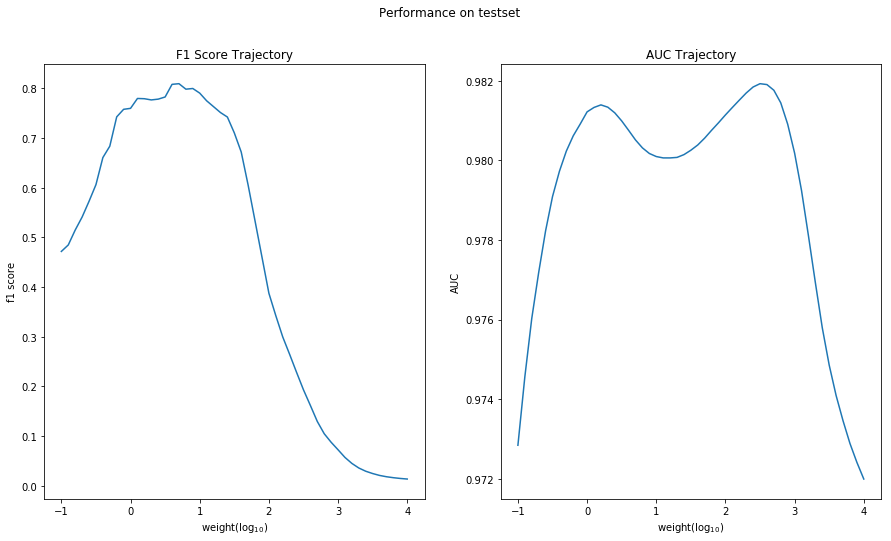

In [10]:
fig = plt.figure(figsize = (15, 8))
fig.suptitle('Performance on testset')

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(np.log(weights)/np.log(10), f1_history)
ax1.set_title('F1 Score Trajectory')
ax1.set_xlabel(r'weight($\log_{10}$)')
ax1.set_ylabel('f1 score')

ax2.plot(np.log(weights)/np.log(10), auc_history)
ax2.set_title('AUC Trajectory')
ax2.set_xlabel(r'weight($\log_{10}$)')
ax2.set_ylabel('AUC')

plt.show()

Clearly these curves depends largely on the train/test split so it's not that reliable.